In [1]:
# Initialize Otter
import otter
grader = otter.Notebook()

# Homework 9: Predicting Taxi Ride Duration
## Due Date: Sunday 08/09/20, 11:59PM

Please note that even though we will not grade several questions in this assignment, we still encourage you to complete them as they can help you understand core concepts in this course.

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## Score Breakdown
Question | Points
--- | ---
1a | 2
1b | 2
1c | (ungraded)
2a | 1
2b | (ungraded)
3a | (ungraded)
3b | (ungraded)
3c | (ungraded)
3d | 2
3e | (ungraded)
4a | 2
4b | 2
4c | 2
4d | 2
4e | (ungraded)
4f | 2
4g | 4
Total | 21

## This Assignment
In this assignment, you will use what you've learned in class to create a regression model that predicts the travel time of a taxi ride in New York. 

After this assignment, you should feel comfortable with the following:

- The data science lifecycle: data selection and cleaning, EDA, feature engineering, and model selection.
- Using `sklearn` to process data and fit linear regression models.
- Embedding linear regression as a component in a more complex model.

First, let's import:

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

## The Data
Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The full data set takes a long time to download directly, so we've placed a simple random sample of the data into `taxi.db`, a SQLite database. You can view the code used to generate this sample in the `taxi_sample.ipynb` file included with this assignment (not required).

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

Your goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

## Part 1: Data Selection and Cleaning

In this part, you will limit the data to trips that began and ended on Manhattan Island ([map](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488)). 

### Question 1a
Use a SQL query to load the `taxi` table from `taxi.db` into a Pandas DataFrame called `all_taxi`. 

Only include trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.6 and 40.88 (inclusive of both boundaries)

*Hint*: Your solution will be shorter if you write Python code to generate the SQL query string. Try not to copy and paste code.

*The provided tests check that you have constructed `all_taxi` correctly.*

<!--
BEGIN QUESTION
name: q1a
points: 2
-->

In [3]:
import sqlite3

conn = sqlite3.connect('taxi.db')
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

query = """
SELECT * from taxi
WHERE pickup_lon BETWEEN -74.03 AND -73.75
AND dropoff_lon BETWEEN -74.03 AND -73.75
AND pickup_lat BETWEEN 40.6 AND 40.88
AND dropoff_lat BETWEEN 40.6 AND 40.88
"""

all_taxi = pd.read_sql(query, conn)
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there.

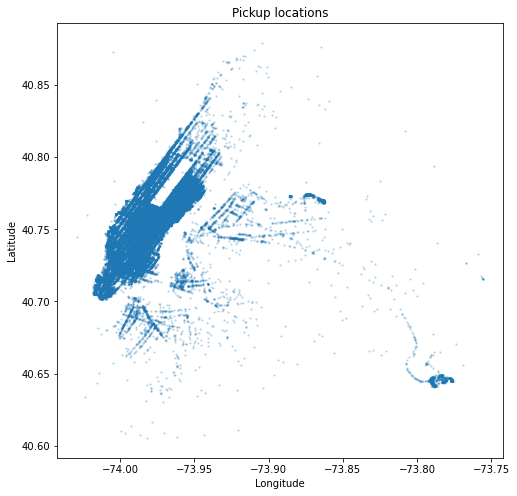

In [5]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.

### Question 1b

Create a DataFrame called `clean_taxi` that only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour. Inequalities should not be strict (e.g., `<=` instead of `<`) unless comparing to 0.

*The provided tests check that you have constructed `clean_taxi` correctly.*

<!--
BEGIN QUESTION
name: q1b
points: 2
-->

In [6]:
clean_taxi = all_taxi.loc[(all_taxi['passengers'] > 0) & (all_taxi['distance'] > 0) & 
                          (all_taxi['duration'] >= 60) & (all_taxi['duration'] <= 3600) & 
                          ((all_taxi['distance'] / (all_taxi['duration']/3600)) <= 100)]
clean_taxi

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
...,...,...,...,...,...,...,...,...,...
97687,2016-01-31 02:59:16,2016-01-31 03:09:23,-73.997391,40.721027,-73.978447,40.745277,1,2.17,607
97688,2016-01-14 22:48:10,2016-01-14 22:51:27,-73.988037,40.718761,-73.983337,40.726162,1,0.60,197
97689,2016-01-08 04:46:37,2016-01-08 04:50:12,-73.984390,40.754978,-73.985909,40.751820,4,0.79,215
97690,2016-01-31 12:55:54,2016-01-31 13:01:07,-74.008675,40.725979,-74.009598,40.716003,1,0.85,313


In [7]:
grader.check("q1b")

q1b results: All test cases passed!

We then create a DataFrame called `manhattan_taxi` that only includes trips from `clean_taxi` that start and end within a polygon that defines the boundaries of [Manhattan Island](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

The vertices of this polygon are defined in `manhattan.csv` as (latitude, longitude) pairs, which are [published here](https://gist.github.com/baygross/5430626).

An efficient way to test if a point is contained within a polygon is [described on this page](http://alienryderflex.com/polygon/). 

We have provided the implementation for you.

In [8]:
polygon = pd.read_csv('manhattan.csv')

def in_manhattan(x, y):
    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""
    j = polygon.shape[0]-1
    odd = False
    for i in range(polygon.shape[0]):
        xsi, xsj, ysi, ysj = xs[i], xs[j], ys[i], ys[j]
        if (ysi < y <= ysj) or (ysj < y <= ysi):
            z = (y - ysi) / (ysj - ysi) * (xsj - xsi)
            if xsi + z < x: 
                odd = not odd
        j = i
    return odd


import os

xs, ys = polygon['lon'], polygon['lat']

def trip_in_manhattan(row):
    pickup = in_manhattan(row['pickup_lon'], row['pickup_lat'])
    dropoff = in_manhattan(row['dropoff_lon'], row['dropoff_lat'])
    return pickup and dropoff

if os.path.exists('manhattan_taxi.csv'):
    manhattan_taxi = pd.read_csv('manhattan_taxi.csv')
    
if 'manhattan_taxi' not in dir():
    manhattan_taxi = clean_taxi[clean_taxi.apply(trip_in_manhattan, axis=1)]
    manhattan_taxi.to_csv('manhattan_taxi.csv', index=False)

manhattan_taxi = manhattan_taxi

A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

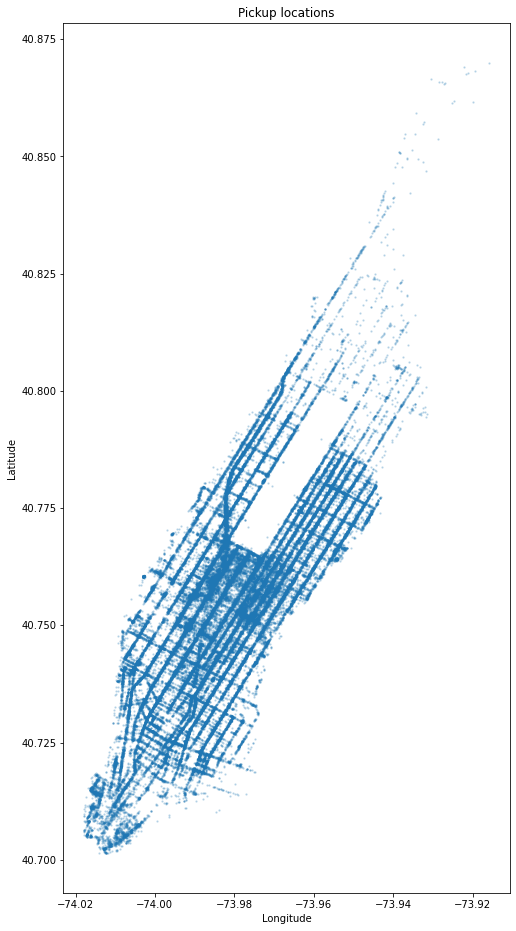

In [9]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

### Question 1c (ungraded)

**In the following cell**, print a summary of the data selection and cleaning you performed. For example, you should print something like: "Of the original 1000 trips, 21 anomolous trips (2.1%) were removed through data cleaning, and then the 600 trips within Manhattan were selected for further analysis." (Note that the numbers in this example are not accurate.)

**Your Python code should not include any number literals, but instead should refer to the shape of `all_taxi`, `clean_taxi`, and `manhattan_taxi`.** Your response will be scored based on whether you generate an accurate description and do not include any number literals in your Python expression, but instead refer to the dataframes you have created.



One way to do this is with [Python's f-strings](https://realpython.com/python-f-strings/). For instance,

```
name = "Joshua"
print(f"Hi {name}, how are you?")
```

prints `Hi Joshua, how are you?`.


In [10]:
all_trips = len(all_taxi)
clean_trips = len(clean_taxi)
manhattan_trips = len(manhattan_taxi)

print(f"Of the original {all_trips} trips, {all_trips - clean_trips} trips ("+"{:.2%}".format((all_trips - clean_trips) / all_trips) + ") were removed through data cleaning, and then the {manhattan_trips} trips within Manhattan were selected for further analysis.")

Of the original 97692 trips, 1247 trips (1.28%) were removed through data cleaning, and then the {manhattan_trips} trips within Manhattan were selected for further analysis.


## Part 2: Exploratory Data Analysis

In this part, you'll choose which days to include as training data in your regression model. 

Your goal is to develop a general model that could potentially be used for future taxi rides. There is no guarantee that future distributions will resemble observed distributions, but some effort to limit training data to typical examples can help ensure that the training data are representative of future observations.

January 2016 had some atypical days. New Years Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

### Question 2a

Add a column labeled `date` to `manhattan_taxi` that contains the date (but not the time) of pickup, formatted as a `datetime.date` value ([docs](https://docs.python.org/3/library/datetime.html#date-objects)). 

*The provided tests check that you have extended `manhattan_taxi` correctly.*

<!--
BEGIN QUESTION
name: q2a
points: 1
-->

In [11]:
import datetime as dt
manhattan_taxi['date'] = pd.to_datetime(manhattan_taxi['pickup_datetime']).dt.date
manhattan_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,2,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
3,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
4,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


In [12]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b (ungraded)

Create a data visualization that allows you to identify which dates were affected by the historic blizzard of January 2016. Make sure that the visualization type is appropriate for the visualized data.

_Hint: How do you expect taxi usage to differ on blizzard days?_


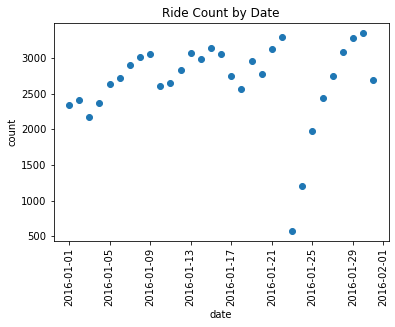

In [13]:
date_ride_count = manhattan_taxi.groupby('date').count()
date_ride_count = pd.DataFrame(date_ride_count['pickup_datetime']).reset_index().rename(columns={'pickup_datetime': 'ride count'})
plt.plot_date(date_ride_count['date'], date_ride_count['ride count'])
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('count')
plt.title('Ride Count by Date');

Finally, we have generated a list of dates that should have a fairly typical distribution of taxi rides, which excludes holidays and blizzards. The cell below assigns `final_taxi` to the subset of `manhattan_taxi` that is on these days. (No changes are needed; just run this cell.)

In [14]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



You are welcome to perform more exploratory data analysis, but your work will not be scored. Here's a blank cell to use if you wish. In practice, further exploration would be warranted at this point, but we won't require that of you.

In [15]:
# Optional: More EDA here

## Part 3: Feature Engineering

In this part, you'll create a design matrix (i.e., feature matrix) for your linear regression model. You decide to predict trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

You will ensure that the process of transforming observations into a design matrix is expressed as a Python function called `design_matrix`, so that it's easy to make predictions for different samples in later parts of the assignment.

Because you are going to look at the data in detail in order to define features, it's best to split the data into training and test sets now, then only inspect the training set.

In [16]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)


### Question 3a (ungraded)

Create a box plot that compares the distributions of taxi trip durations for each day **using `train` only**. Individual dates shoud appear on the horizontal axis, and duration values should appear on the vertical axis. Your plot should look like the following.

_Hint: Use `sns.boxplot`._

![](images/3a_resized.png)


Text(0.5, 1.0, 'Duration by date')

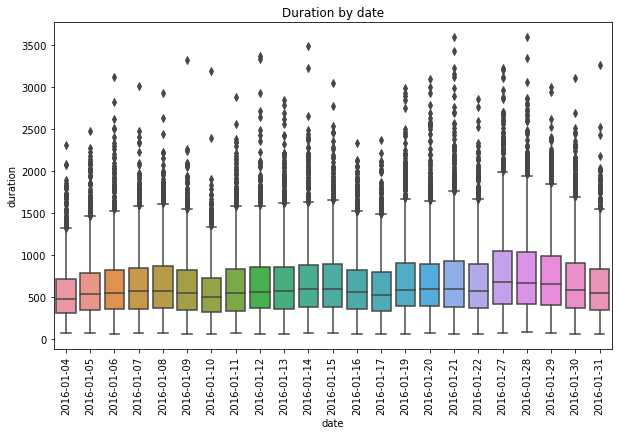

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train.sort_values('date'), x = 'date', y = 'duration')
plt.xticks(rotation=90)
plt.title('Duration by date')

### Question 3b (ungraded)

In one or two sentences, describe the assocation between the day of the week and the duration of a taxi trip. This question will be graded on whether your answer is justified by your boxplot and if it is at least somewhat meaningful.

*Note*: The end of Part 2 showed a calendar for these dates and their corresponding days of the week.

_Type your answer here, replacing this text._

Below, the provided `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.

No changes are required; just run this cell.

In [18]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)
train.iloc[0,:] # An example row

pickup_datetime     2016-01-21 18:02:20
dropoff_datetime    2016-01-21 18:27:54
pickup_lon                   -73.994202
pickup_lat                    40.751019
dropoff_lon                  -73.963692
dropoff_lat                   40.771069
passengers                            1
distance                           2.77
duration                           1534
date                         2016-01-21
hour                                 18
day                                   3
weekend                               0
period                                3
speed                          6.500652
Name: 14043, dtype: object

### Question 3c (ungraded)

Use `sns.distplot` to create an overlaid histogram comparing the distribution of average speeds for taxi rides that start in the early morning (12am-6am), day (6am-6pm; 12 hours), and night (6pm-12am; 6 hours). Your plot should look like this:

![](images/3c_speeds.png)


/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/huangweijun/anaconda/envs/cs188/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a fi

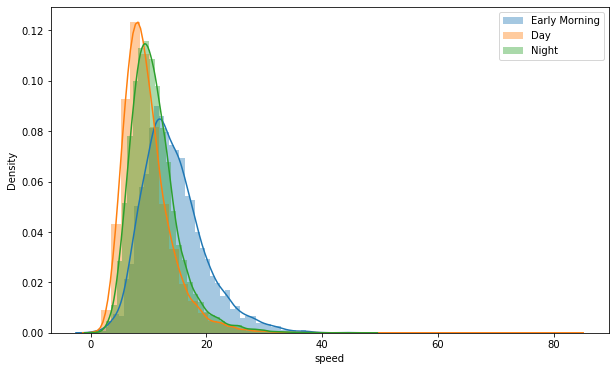

In [19]:
plt.figure(figsize=(10, 6))
period1 = train[train['period'] == 1]['speed']
period2 = train[train['period'] == 2]['speed']
period3 = train[train['period'] == 3]['speed']
sns.distplot(period1, label='Early Morning')
sns.distplot(period2, label='Day')
sns.distplot(period3, label='Night')
plt.legend();

It looks like the time of day is associated with the average speed of a taxi ride.

### Question 3d

Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). Before doing that, let's once again take a look at a scatterplot of trips in Manhattan:

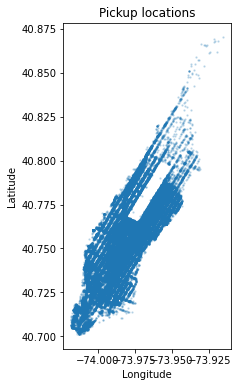

In [20]:
plt.figure(figsize=(3, 6))
pickup_scatter(manhattan_taxi)

Add a `region` column to `train` that categorizes each pick-up location as 0, 1, or 2 based on the value of each point's first principal component, such that an equal number of points fall into each region. 

Read the documentation of [`pd.qcut`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.qcut.html), which categorizes points in a distribution into equal-frequency bins.

You don't need to add any lines to this solution. Just fill in the assignment statements to complete the implementation.

_Hint: If we have a matrix of latitudes and longitudes of each trip's pickup location, roughly in which direction should PC1 be, based on the above scatterplot?_

*The provided tests ensure that you have answered the question correctly.*

<!--
BEGIN QUESTION
name: q3d
points: 2
-->

In [21]:
# Find the first principal component
D = train[['pickup_lon', 'pickup_lat']].to_numpy()
pca_n = len(train)
pca_means = np.mean(D, axis=0)
X = D - pca_means
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['pickup_lon', 'pickup_lat']].to_numpy()
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = D - pca_means 
    first_pc = X @ vt.T[0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

In [22]:
grader.check("q3d")

q3d results: All test cases passed!

Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). No prior knowledge of New York geography was required!

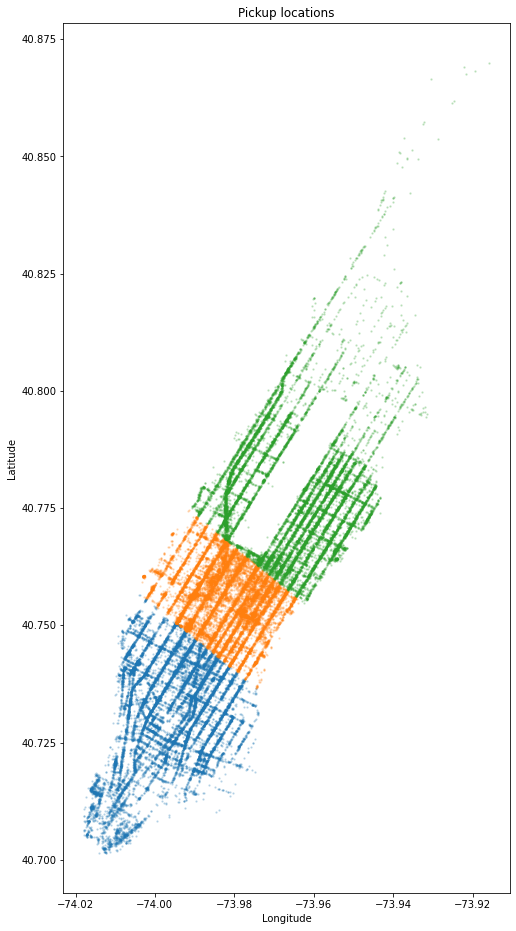

In [23]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

### Question 3e (ungraded)

Use `sns.distplot` to create an overlaid histogram comparing the distribution of speeds for nighttime taxi rides (6pm-12am) in the three different regions defined above. Does it appear that there is an association between region and average speed during the night?

In [24]:
...

Ellipsis

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [25]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]  

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 14043, dtype: float64

## Part 4: Model Selection

In this part, you will select a regression model to predict the duration of a taxi ride.

**Important:** *Tests in this part do not confirm that you have answered correctly. Instead, they check that you're somewhat close in order to detect major errors. It is up to you to calculate the results correctly based on the question descriptions.*

### Question 4a

Assign `constant_rmse` to the root mean squared error on the test set for a constant model that always predicts the mean duration of all training set taxi rides.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [39]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

constant_rmse = rmse(test['duration'] - np.mean(train['duration']))
constant_rmse

399.1437572352666

In [40]:
grader.check("q4a")

q4a results: All test cases passed!

### Question 4b

Assign `simple_rmse` to the root mean squared error on the test set for a simple linear regression model that uses only the distance of the taxi ride as a feature (and includes an intercept).

*Terminology Note*: Simple linear regression means that there is only one feature. Multiple linear regression means that there is more than one. In either case, you can use the `LinearRegression` model from `sklearn` to fit the parameters to data.

<!--
BEGIN QUESTION
name: q4b
points: 2
-->

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(train[['distance']], train.loc[:, 'duration'])
simple_rmse = rmse(test['duration'] - model.predict(test[['distance']]))
simple_rmse

276.7841105000342

In [42]:
grader.check("q4b")

q4b results: All test cases passed!

### Question 4c

Assign `linear_rmse` to the root mean squared error on the test set for a linear regression model fitted to the training set without regularization, using the design matrix defined by the `design_matrix` function from Part 3.

*The provided tests check that you have answered the question correctly and that your `design_matrix` function is working as intended.*

<!--
BEGIN QUESTION
name: q4c
points: 2
-->

In [43]:
model = LinearRegression()
model = model.fit(design_matrix(train), train.loc[:, 'duration'])
linear_rmse = rmse(test['duration'] - model.predict(design_matrix(test)))
linear_rmse

255.1914663188275

In [44]:
grader.check("q4c")

q4c results: All test cases passed!

### Question 4d

For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.  Assign `period_rmse` to the root mean squared error on the test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters. Again, fit to the training set and use the `design_matrix` function for features.

<!--
BEGIN QUESTION
name: q4d
points: 2
-->

In [45]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    model = model.fit(design_matrix(train[train['period'] == v]), train[train['period'] == v].loc[:, 'duration'])
    errors = np.append(errors, test[test['period'] == v]['duration'] - model.predict(design_matrix(test[test['period'] == v])))
    
period_rmse = rmse(np.array(errors))
period_rmse

246.6286883116517

In [46]:
grader.check("q4d")

q4d results: All test cases passed!

This approach is a simple form of decision tree regression, where a different regression function is estimated for each possible choice among a collection of choices. In this case, the depth of the tree is only 1.

### Question 4e (ungraded)

In one or two sentences, explain how the `period` regression model could possibly outperform the linear regression model, even when the design matrix of the latter includes one feature for each possible hour.


_Type your answer here, replacing this text._

### Question 4f

Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

Assign `speed_rmse` to the root mean squared error in the **duration** predicted by a model that first predicts speed as a linear combination of features from the `design_matrix` function, fitted on the training set, then calculates duration from the predicted speed and observed distance.

*Hint*: Speed is in miles per hour, but duration is measured in seconds. You'll need the fact that there are 60 * 60 = 3,600 seconds in an hour.

<!--
BEGIN QUESTION
name: q4f
points: 2
-->

In [47]:
model = LinearRegression()
model = model.fit(design_matrix(train), train['speed'])
speed_rmse = rmse(test['duration'] - (test['distance'] * 3600) / (model.predict(design_matrix(test))))
speed_rmse

243.0179836851495

In [48]:
grader.check("q4f")

q4f results: All test cases passed!

At this point, think about why predicting speed leads to a more accurate regression model than predicting duration directly. You don't need to write your answer anywhere.

### Question 4g

Finally, complete the function `tree_regression_errors` (and helper function `speed_error`) that combines the ideas from the two previous models and generalizes to multiple categorical variables.

The `tree_regression_errors` should:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.

You should find that including each of `period`, `region`, and `weekend` improves prediction accuracy, and that predicting speed rather than duration leads to more accurate duration predictions.

_Hint: Use `print` statements to try and figure out what the skeleton code does, if you're stuck._

<!--
BEGIN QUESTION
name: q4g
points: 4
-->

In [52]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    return duration_error(observations['distance'] * 3600 / predictions, observations)

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train[v_train[c]==v]
            v_test = v_test[v_test[c]==v]
            print(v_train.shape, v_test.shape)
        model.fit(design_matrix(v_train), v_train.loc[:, outcome])
        errors = np.append(errors, error_fn(model.predict(design_matrix(v_test)), v_test))
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

(4868, 16) (1264, 16)
(2584, 16) (665, 16)
(980, 16) (250, 16)
(4868, 16) (1264, 16)
(2584, 16) (665, 16)
(1604, 16) (415, 16)
(4868, 16) (1264, 16)
(1450, 16) (373, 16)
(792, 16) (201, 16)
(4868, 16) (1264, 16)
(1450, 16) (373, 16)
(658, 16) (172, 16)
(4868, 16) (1264, 16)
(834, 16) (226, 16)
(453, 16) (121, 16)
(4868, 16) (1264, 16)
(834, 16) (226, 16)
(381, 16) (105, 16)
(30591, 16) (7585, 16)
(8687, 16) (2165, 16)
(6508, 16) (1613, 16)
(30591, 16) (7585, 16)
(8687, 16) (2165, 16)
(2179, 16) (552, 16)
(30591, 16) (7585, 16)
(9927, 16) (2472, 16)
(7728, 16) (1942, 16)
(30591, 16) (7585, 16)
(9927, 16) (2472, 16)
(2199, 16) (530, 16)
(30591, 16) (7585, 16)
(11977, 16) (2948, 16)
(9283, 16) (2258, 16)
(30591, 16) (7585, 16)
(11977, 16) (2948, 16)
(2694, 16) (690, 16)
(18221, 16) (4572, 16)
(6623, 16) (1644, 16)
(4905, 16) (1224, 16)
(18221, 16) (4572, 16)
(6623, 16) (1644, 16)
(1718, 16) (420, 16)
(18221, 16) (4572, 16)
(6516, 16) (1628, 16)
(5135, 16) (1285, 16)
(18221, 16) (4572, 16)

In [53]:
grader.check("q4g")

q4g results: All test cases passed!

Here's a summary of your results:

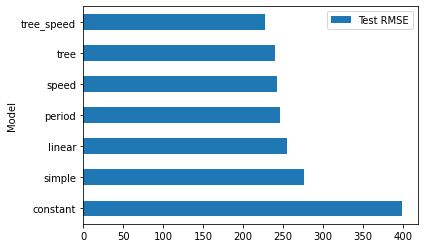

In [54]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

**Congratulations**! You've carried out the entire data science lifecycle for a challenging regression problem. 

In Part 1 on data selection, you solved a domain-specific programming problem relevant to the analysis when choosing only those taxi rides that started and ended in Manhattan.

In Part 2 on EDA, you used the data to assess the impact of a historical event---the 2016 blizzard---and filtered the data accordingly.

In Part 3 on feature engineering, you used PCA to divide up the map of Manhattan into regions that roughly corresponded to the standard geographic description of the island.

In Part 4 on model selection, you found that using linear regression in practice can involve more than just choosing a design matrix. Tree regression made better use of categorical variables than linear regression. The domain knowledge that duration is a simple function of distance and speed allowed you to predict duration more accurately by first predicting speed.

Hopefully, it is apparent that all of these steps are required to reach a reliable conclusion about what inputs and model structure are helpful in predicting the duration of a taxi ride in Manhattan. 

## Future Work

Here are some questions to ponder:

- The regression model would have been more accurate if we had used the date itself as a feature instead of just the day of the week. Why didn't we do that?
- Does collecting this information about every taxi ride introduce a privacy risk? The original data also included the total fare; how could someone use this information combined with an individual's credit card records to determine their location?
- Why did we treat `hour` as a categorical variable instead of a quantitative variable? Would a similar treatment be beneficial for latitude and longitude?
- Why are Google Maps estimates of ride time much more accurate than our estimates?


Here are some possible extensions to the assignment:

- An alternative to throwing out atypical days is to condition on a feature that makes them atypical, such as the weather or holiday calendar. How would you do that?
- Training a different linear regression model for every possible combination of categorical variables can overfit. How would you select which variables to include in a decision tree instead of just using them all?
- Your models use the observed distance as an input, but the distance is only observed after the ride is over. How could you estimate the distance from the pick-up and drop-off locations?
- How would you incorporate traffic data into the model?

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before     running the cell below, so that all images/graphs appear in the output. The cell below will generate     a zipfile for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)